In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from arima_model_function import arima_model, plot_arima_results, plot_acf_pcf

In [3]:
def can_cpi_df_setup(url):
    df = pd.read_csv(url)
    df['REF_DATE'] = pd.to_datetime(df['REF_DATE'])
    df = df[(df['REF_DATE'].dt.year >= 2015) & (df['REF_DATE'].dt.year < 2020)]
    # Change date name to match the US dataset
    df = df.rename(columns = {'REF_DATE': 'Date'})
    df = df[df['GEO'] == 'Canada']
    return df

In [4]:
can_cpi_df = can_cpi_df_setup(r"C:\Users\aswir\OneDrive\Documents\Capstone Project\18100004.csv")
can_cpi_df.head()

C:\Users\aswir\AppData\Local\Temp\ipykernel_51476\3103944337.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


,Date,GEO,DGUID,Products and product groups,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
868614,2015-01-01,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,124.3,NaN,NaN,NaN,1
868615,2015-01-01,Canada,2016A000011124,Food,2002=100,17,units,0,v41690974,2.3,139.1,NaN,NaN,NaN,1
868616,2015-01-01,Canada,2016A000011124,Food purchased from stores,2002=100,17,units,0,v41690975,2.4,139.7,NaN,NaN,NaN,1
868617,2015-01-01,Canada,2016A000011124,Meat,2002=100,17,units,0,v41690976,2.5,153.8,NaN,NaN,NaN,1
868618,2015-01-01,Canada,2016A000011124,Fresh or frozen meat (excluding poultry),2002=100,17,units,0,v41690977,2.6,163.1,NaN,NaN,NaN,1


In [5]:
#First six rows are unneeded meta data describing other things
mapping_df = pd.read_csv(r"C:\Users\aswir\OneDrive\Documents\Capstone Project\18100004_MetaData.csv", skiprows=6)

#first 29 rows are related to provinces and locations which we are not interested in
mapping_df = mapping_df.iloc[29:].reset_index(drop=True)
#final df has the member_id and the parent_id which I can use to map each group to it's overall category

mapping_df.drop(columns=['Member Notes', 'Member Definitions', 'Classification Code', 'Terminated'], inplace=True)

mapping_df['Member ID'] = pd.to_numeric(mapping_df['Member ID'], errors='coerce').astype('Int64')  # Use 'Int64' to preserve NaNs
mapping_df['Parent Member ID'] = pd.to_numeric(mapping_df['Parent Member ID'], errors='coerce').astype('Int64')  # Use 'Int64' to preserve NaNs

mapping_df.head(10)

,Dimension ID,Member Name,Member ID,Parent Member ID
0,1,Canada,2,<NA>
1,2,"Recreation, education and reading",219,2
2,2,"Alcoholic beverages, tobacco products and recr...",256,2
3,2,Food,3,2
4,2,Shelter,79,2
5,2,"Household operations, furnishings and equipment",96,2
6,2,Clothing and footwear,139,2
7,2,Transportation,176,2
8,2,Health and personal care,201,2
9,2,Food purchased from stores,4,3


In [6]:
def get_base_children(df, parent_member_id):
    base_children_df = df.loc[df['Parent Member ID'] == parent_member_id, ['Member Name', 'Member ID']]

    base_children_names = base_children_df['Member Name'].to_list()
    base_children_ids = base_children_df['Member ID'].to_list()


    parent_name = df.loc[df['Member ID'] == parent_member_id, 'Member Name'].to_list()
    parent_name = parent_name[-1]

    base_children_names.append(parent_name)
    base_children_ids.append(parent_member_id)

    return base_children_names, base_children_ids

In [7]:
base_categories = get_base_children(mapping_df,79)[0]
base_category_ids = get_base_children(mapping_df, 79)[1]
print(base_categories)
print(base_category_ids)

['Rented accommodation', 'Owned accommodation', 'Water, fuel and electricity', 'Shelter']
[80, 84, 91, 79]


In [8]:
categories = ['Food','Food purchased from restaurants', 'Food purchased from stores', 'Fish, seafood and other marine products', 'Dairy products and eggs', 'Meat',
              'Shelter', 'Owned accommodation', 'Rented accommodation', 'Water, fuel and electricity',
              'Clothing and footwear', 'Footwear', 'Clothing', 'Clothing accessories, watches and jewellery',
              'Transportation', 'Public transportation', 'Private transportation', 'Gasoline']
print(len(categories))


18


In [9]:
def prepare_categories(df, categories):
    pivoted_df = df[df['Products and product groups'].isin(categories)][['Date', 'Products and product groups', 'VALUE']].pivot(
        index='Date', columns='Products and product groups', values='VALUE')
    return pivoted_df

In [10]:
can_categories_df = prepare_categories(can_cpi_df, categories)
print(len(can_categories_df))
print("Base Categories:", categories)
print("DataFrame Columns:", can_categories_df.columns.tolist())
print(len(can_categories_df.columns))

60
Base Categories: ['Food', 'Food purchased from restaurants', 'Food purchased from stores', 'Fish, seafood and other marine products', 'Dairy products and eggs', 'Meat', 'Shelter', 'Owned accommodation', 'Rented accommodation', 'Water, fuel and electricity', 'Clothing and footwear', 'Footwear', 'Clothing', 'Clothing accessories, watches and jewellery', 'Transportation', 'Public transportation', 'Private transportation', 'Gasoline']
DataFrame Columns: ['Clothing', 'Clothing accessories, watches and jewellery', 'Clothing and footwear', 'Dairy products and eggs', 'Fish, seafood and other marine products', 'Food', 'Food purchased from restaurants', 'Food purchased from stores', 'Footwear', 'Gasoline', 'Meat', 'Owned accommodation', 'Private transportation', 'Public transportation', 'Rented accommodation', 'Shelter', 'Transportation', 'Water, fuel and electricity']
18


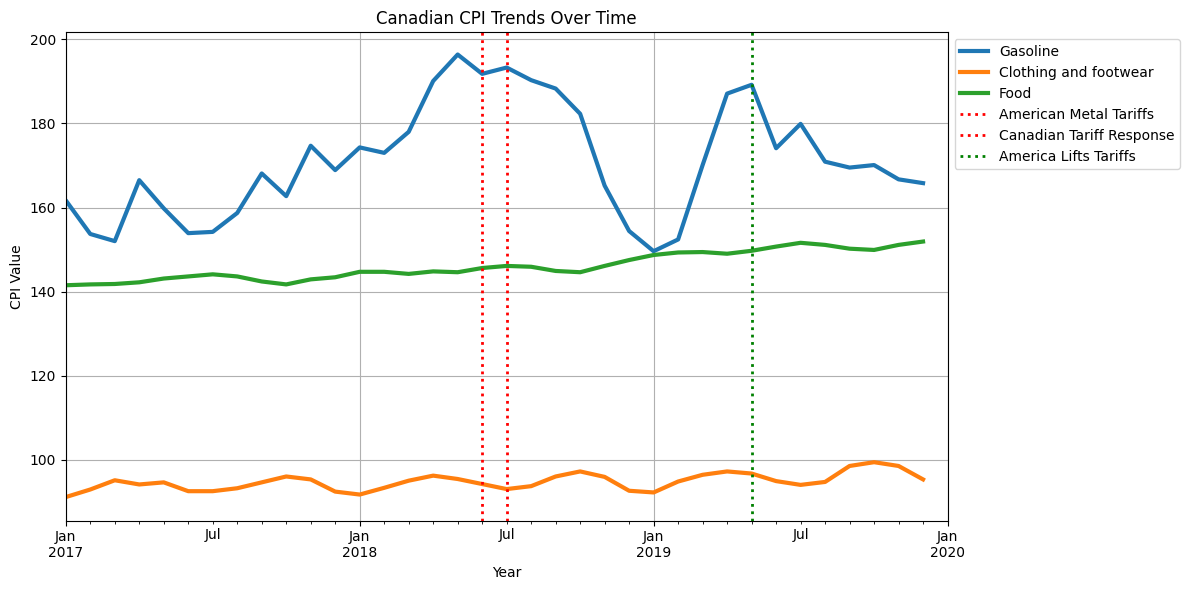

In [11]:
plt.figure(figsize=(12, 6))

# Plot all categories at once
can_categories_df[['Gasoline', 'Clothing and footwear', 'Food']].plot(ax=plt.gca(), linewidth=3)

# Formatting
plt.axvline(pd.Timestamp("2018-06-01"), color="red", linestyle="dotted", linewidth=2, label="American Metal Tariffs")
plt.axvline(pd.Timestamp("2018-07-01"), color="red", linestyle="dotted", linewidth=2, label="Canadian Tariff Response")
plt.axvline(pd.Timestamp("2019-05-17"), color="green", linestyle="dotted", linewidth=2, label="America Lifts Tariffs")

plt.xlabel("Year")
plt.xlim(pd.Timestamp("2017-01-01"), pd.Timestamp("2020-01-01"))
plt.ylabel("CPI Value")
plt.title("Canadian CPI Trends Over Time")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Move legend outside
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



📊 **Augmented Dickey-Fuller (ADF) Test on Differenced Data:**
  p-value: 0.0004 (Stationary ✅)

📊 **In-Sample Evaluation Metrics**
    MAE = 0.6188, MAEP = 0.43%
    RMSE = 0.7611

**Ljung-Box Test (Residuals Autocorrelation):**
  p-value: 0.1470 (No autocorrelation ✅)

📊 **Breusch-Pagan Test (Heteroskedasticity):**
  p-value: 0.4247 (Homoskedastic ✅)

📊 **Model Selection Criteria:**
  AIC: 101.4736


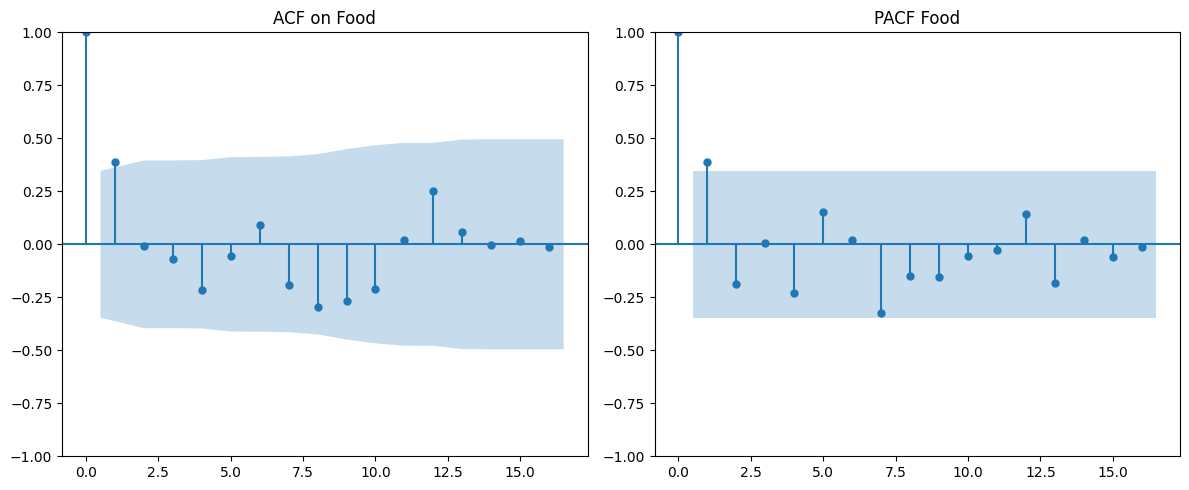

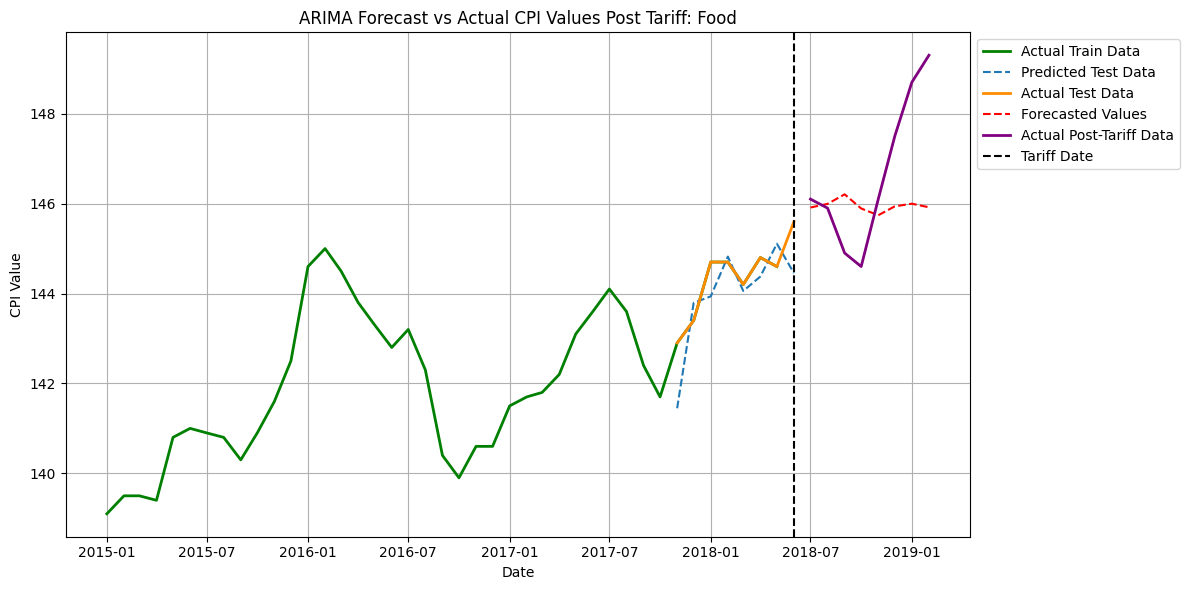


📊 **Augmented Dickey-Fuller (ADF) Test on Differenced Data:**
  p-value: 0.0004 (Stationary ✅)

📊 **In-Sample Evaluation Metrics**
    MAE = 0.5532, MAEP = 0.41%
    RMSE = 0.7044

**Ljung-Box Test (Residuals Autocorrelation):**
  p-value: 0.3524 (No autocorrelation ✅)

📊 **Breusch-Pagan Test (Heteroskedasticity):**
  p-value: 0.5627 (Homoskedastic ✅)

📊 **Model Selection Criteria:**
  AIC: 151.3297


C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


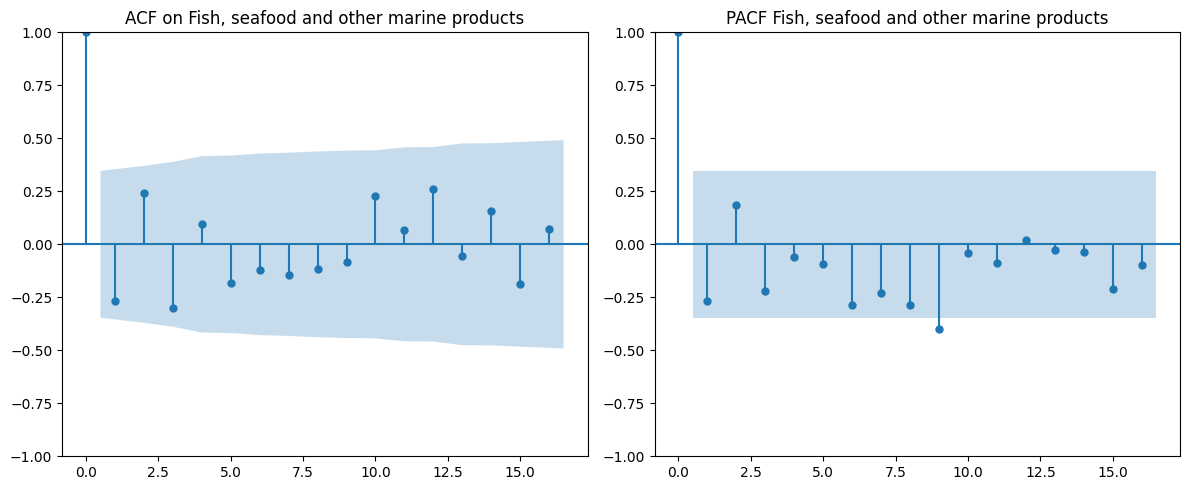

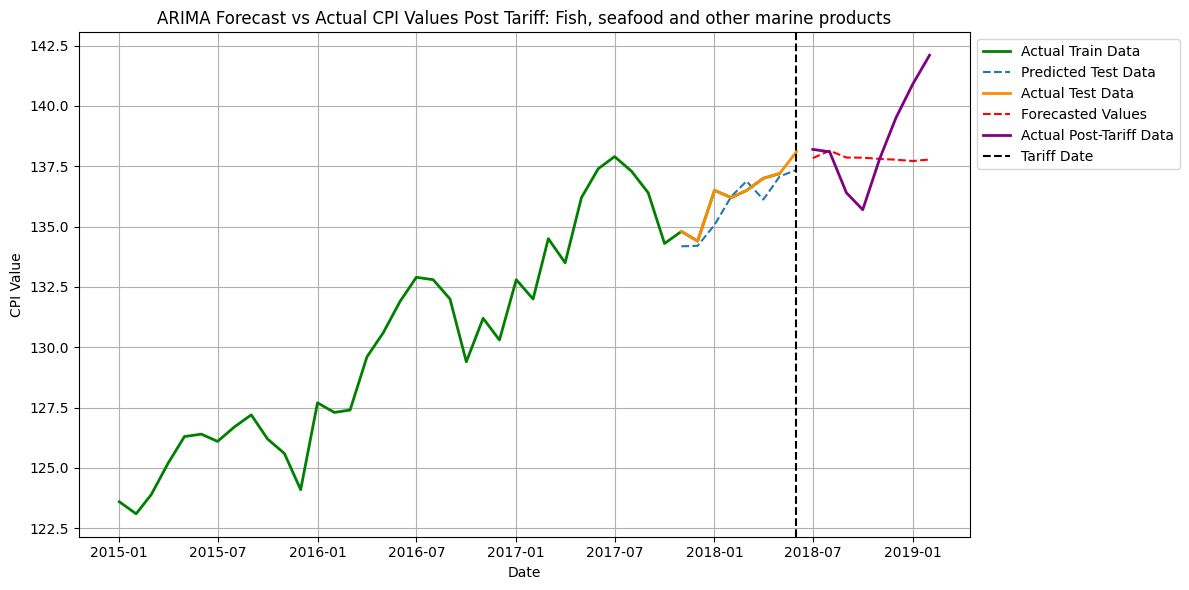

C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



📊 **Augmented Dickey-Fuller (ADF) Test on Differenced Data:**
  p-value: 0.0001 (Stationary ✅)

📊 **In-Sample Evaluation Metrics**
    MAE = 0.4340, MAEP = 0.46%
    RMSE = 0.4916

**Ljung-Box Test (Residuals Autocorrelation):**
  p-value: 0.9689 (No autocorrelation ✅)

📊 **Breusch-Pagan Test (Heteroskedasticity):**
  p-value: 0.6578 (Homoskedastic ✅)

📊 **Model Selection Criteria:**
  AIC: 124.0425


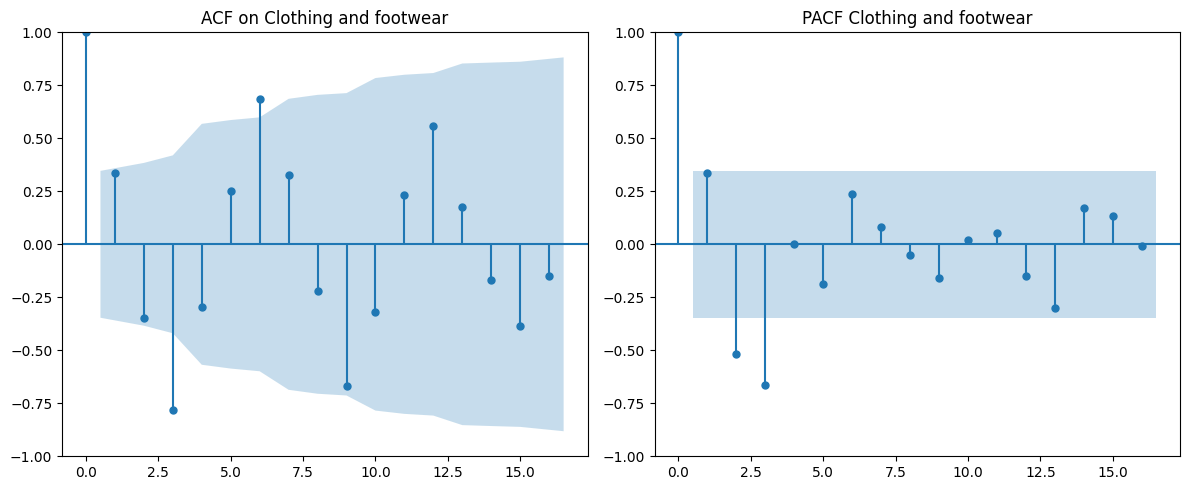

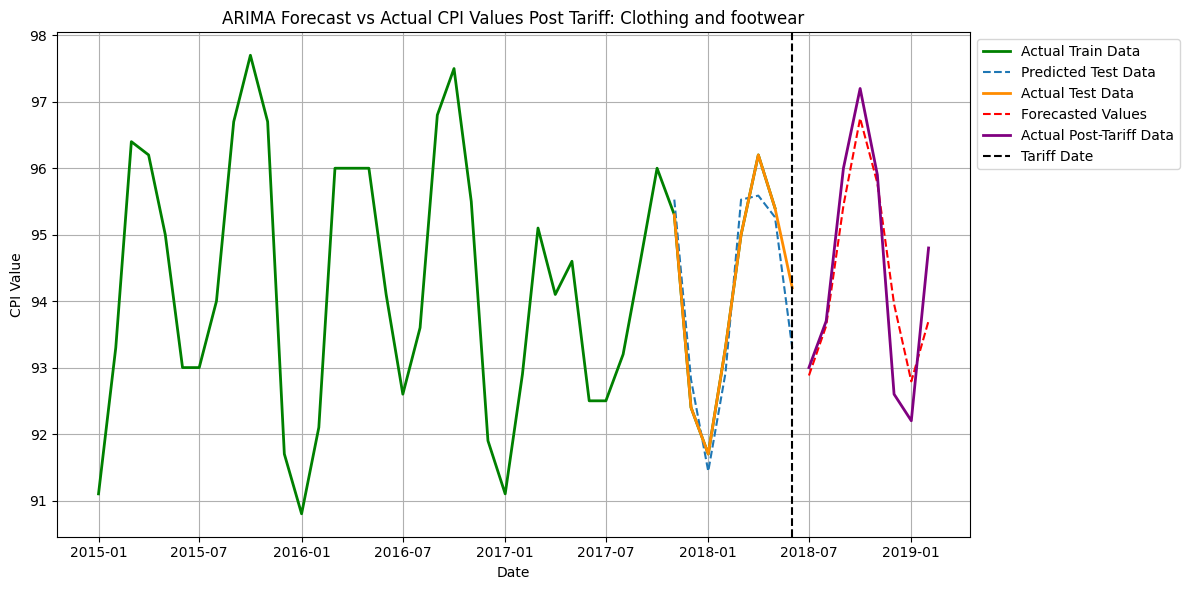

C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



📊 **Augmented Dickey-Fuller (ADF) Test on Differenced Data:**
  p-value: 0.0000 (Stationary ✅)

📊 **In-Sample Evaluation Metrics**
    MAE = 0.6673, MAEP = 0.71%
    RMSE = 0.7585

**Ljung-Box Test (Residuals Autocorrelation):**
  p-value: 0.7044 (No autocorrelation ✅)

📊 **Breusch-Pagan Test (Heteroskedasticity):**
  p-value: 0.9764 (Homoskedastic ✅)

📊 **Model Selection Criteria:**
  AIC: 146.9452


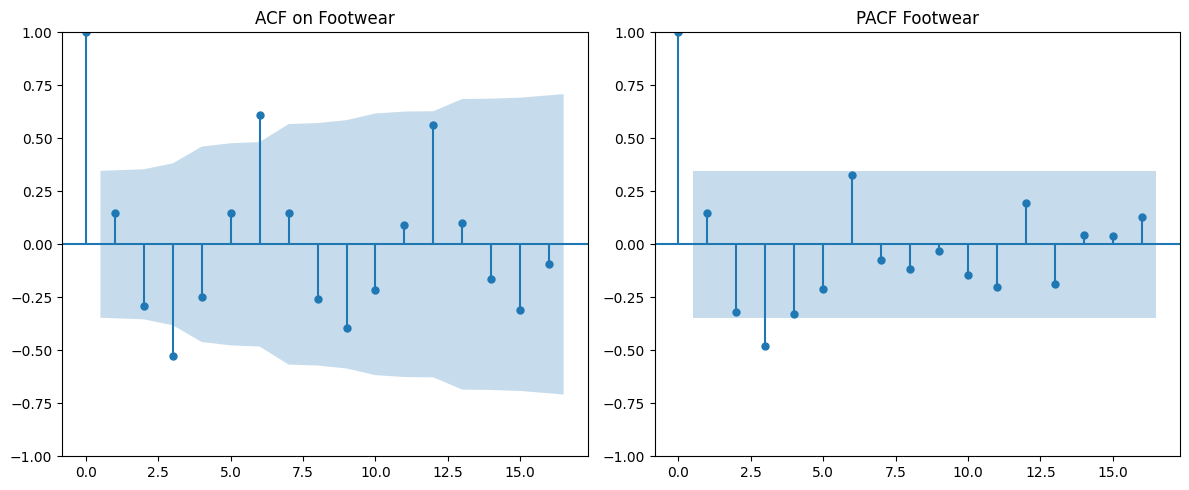

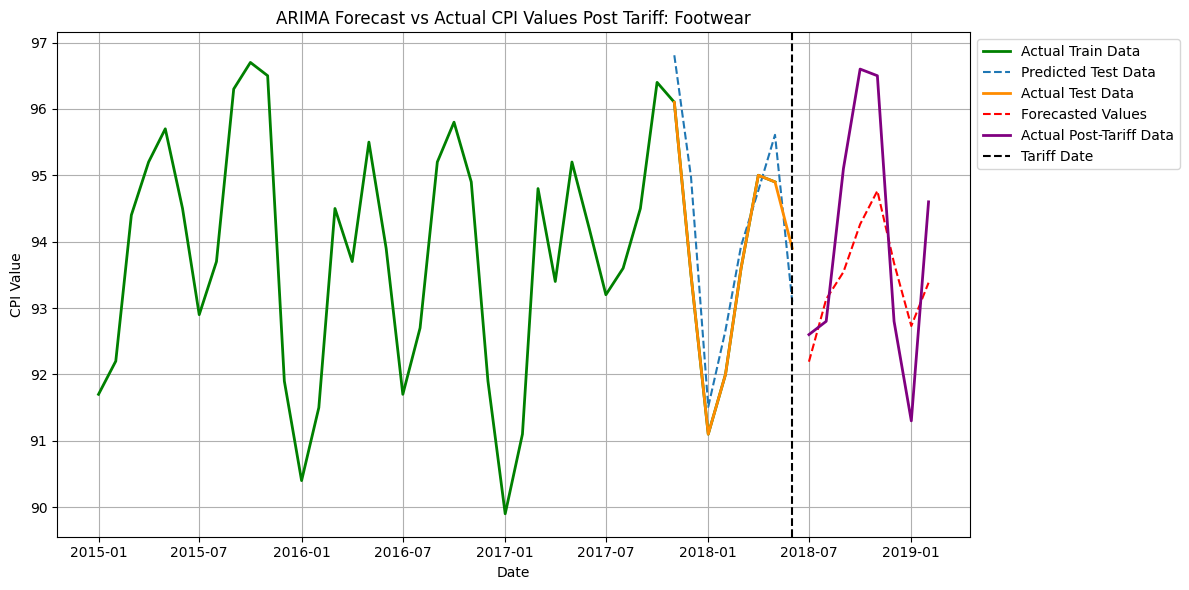


📊 **Augmented Dickey-Fuller (ADF) Test on Differenced Data:**
  p-value: 0.0048 (Stationary ✅)

📊 **In-Sample Evaluation Metrics**
    MAE = 0.6507, MAEP = 0.78%
    RMSE = 0.7702

**Ljung-Box Test (Residuals Autocorrelation):**
  p-value: 0.5592 (No autocorrelation ✅)

📊 **Breusch-Pagan Test (Heteroskedasticity):**
  p-value: 0.3279 (Homoskedastic ✅)

📊 **Model Selection Criteria:**
  AIC: 128.6571


C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


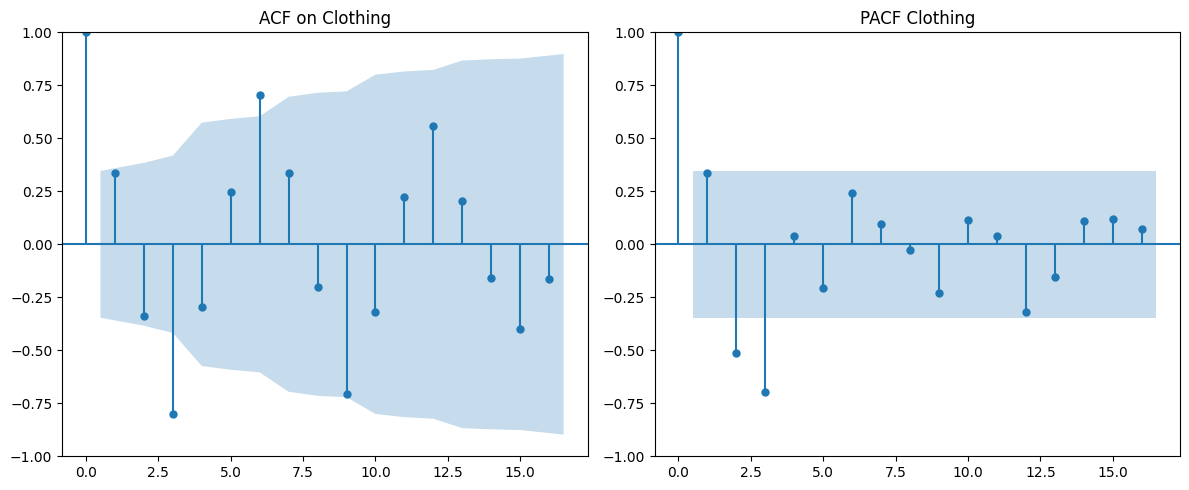

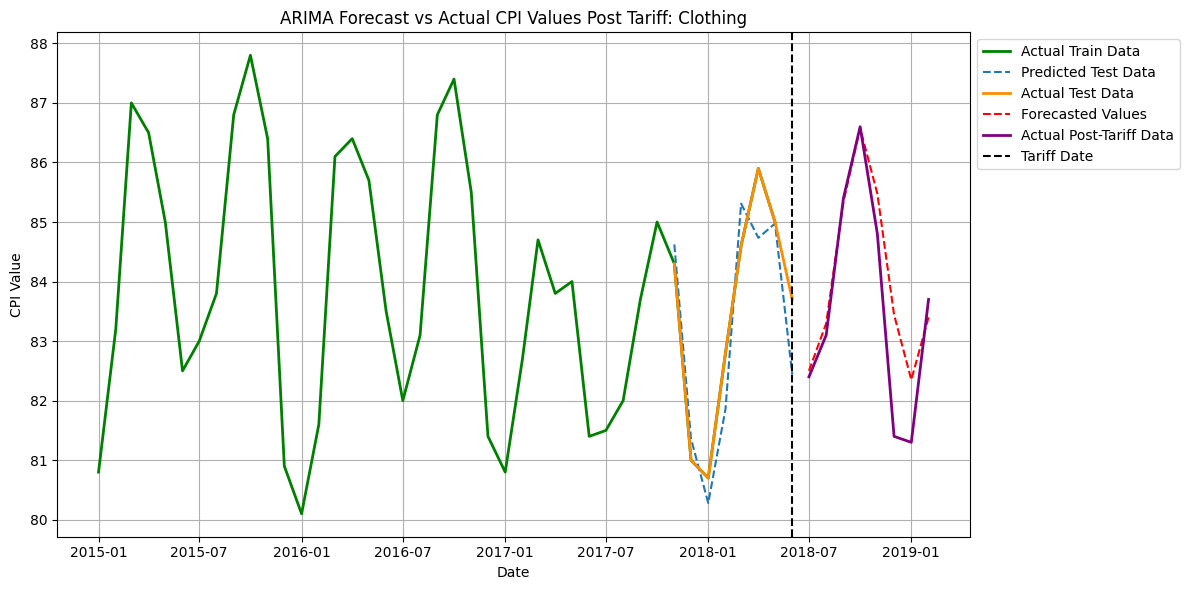

C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



📊 **Augmented Dickey-Fuller (ADF) Test on Differenced Data:**
  p-value: 0.0000 (Stationary ✅)

📊 **In-Sample Evaluation Metrics**
    MAE = 6.9890, MAEP = 3.86%
    RMSE = 7.3739

**Ljung-Box Test (Residuals Autocorrelation):**
  p-value: 0.5681 (No autocorrelation ✅)

📊 **Breusch-Pagan Test (Heteroskedasticity):**
  p-value: 0.8880 (Homoskedastic ✅)

📊 **Model Selection Criteria:**
  AIC: 295.4788


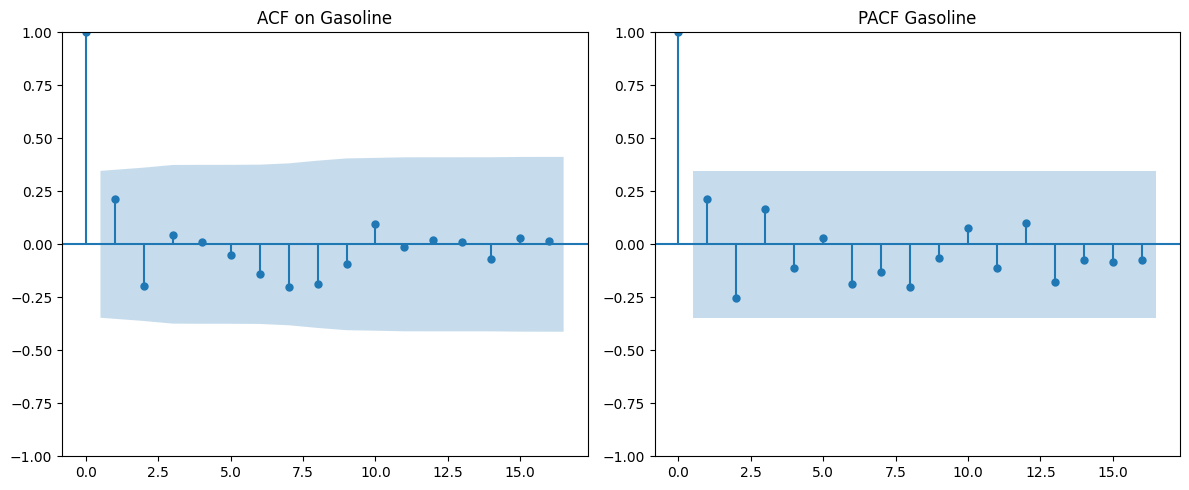

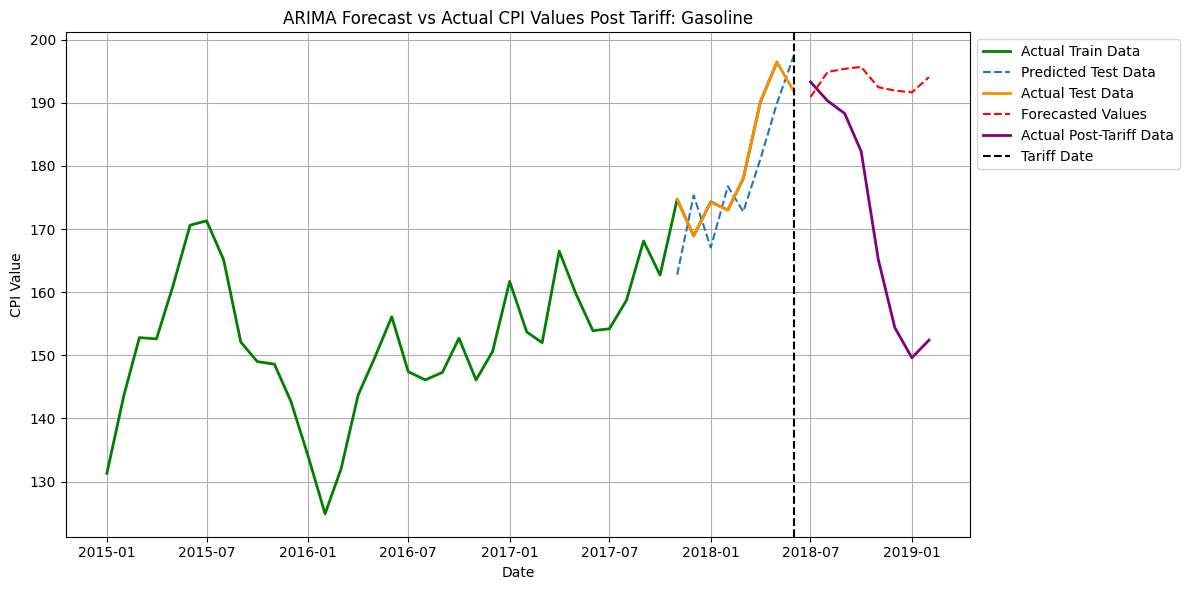

In [15]:
# List of categories included for report
can_cat_list = ['Food', 'Fish, seafood and other marine products', 'Dariy products and eggs', 'Clothing and footwear', 'Clothing', 'Footwear', 'Gasoline']

# Getting ARIMA forecasts for the categories included in the report pre-tariff to post tariff implementation
for i in categories:
    if i in can_cat_list:
        model = arima_model(can_categories_df, i, (5,1,3), '2018-06-01', 8, 8)
        plot_acf_pcf(can_categories_df, i, '2017-10-1', lags=16)
        plot_arima_results(can_categories_df, i, model)


C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


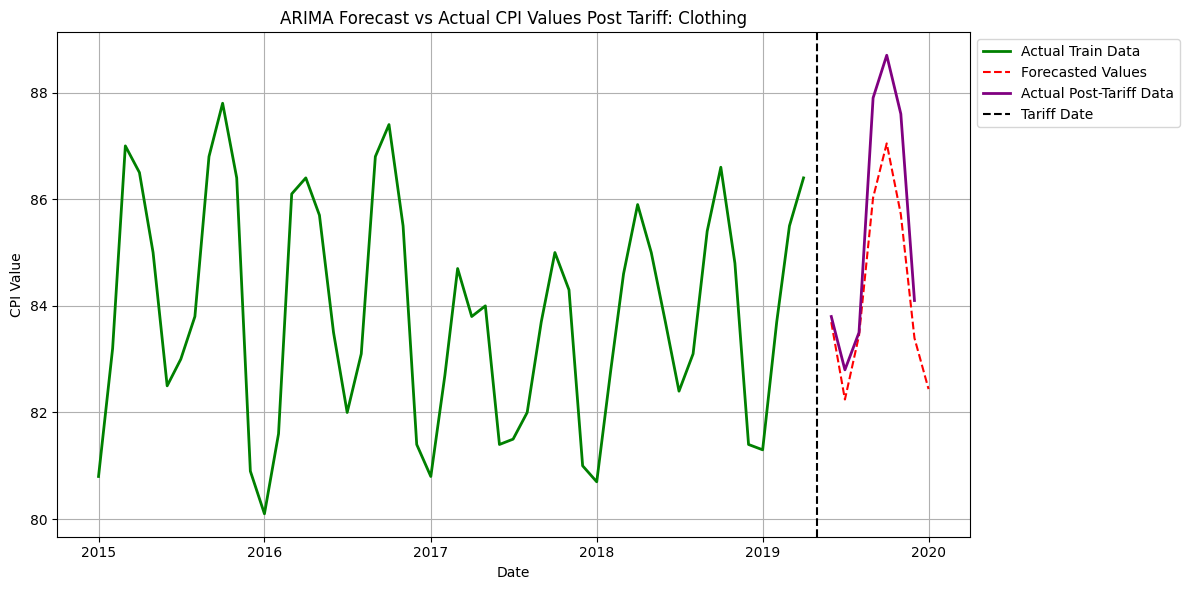

C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


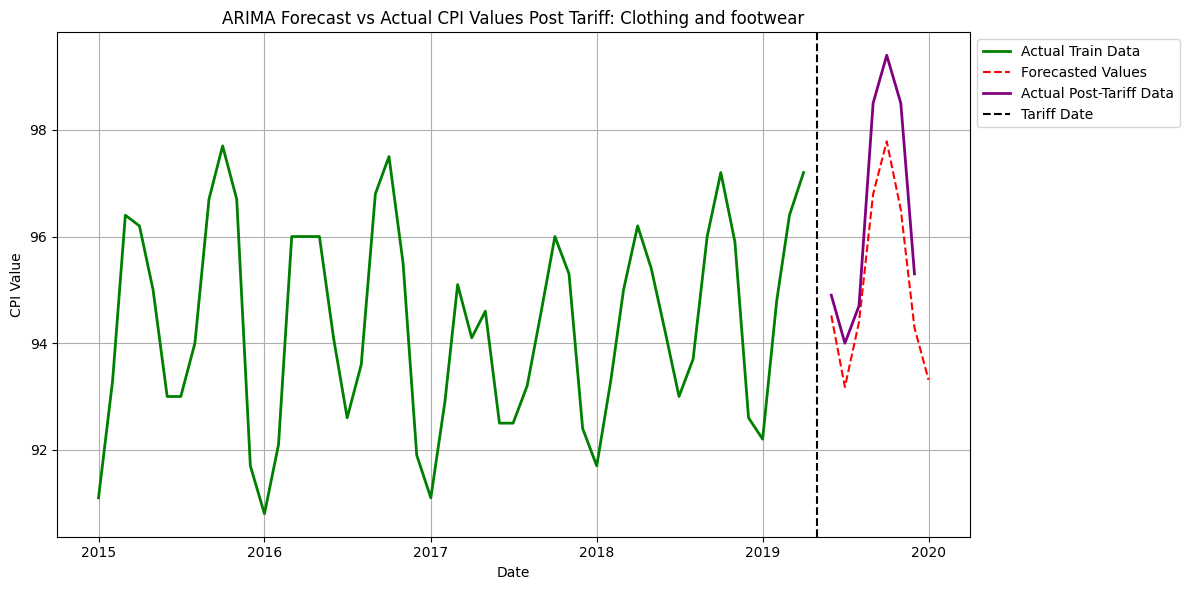

C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


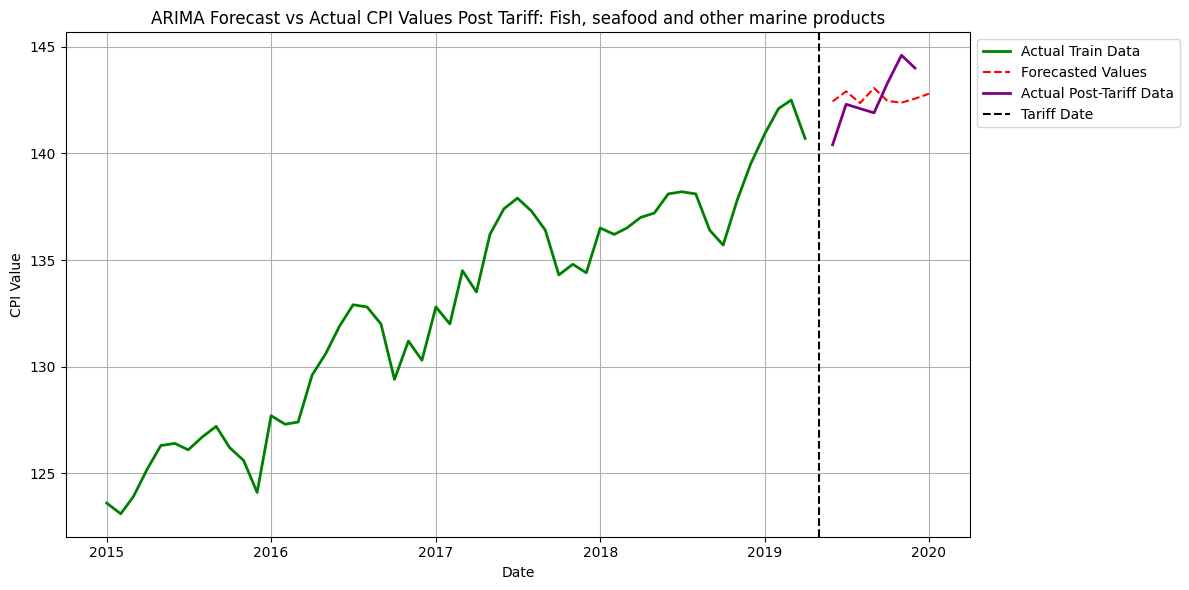

C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


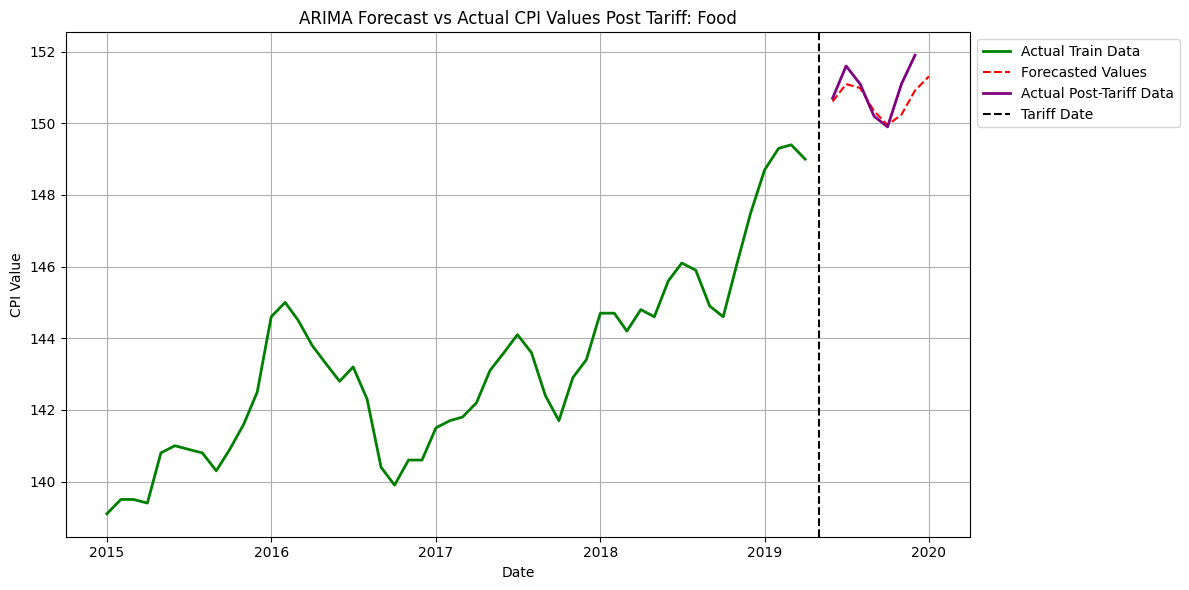

C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


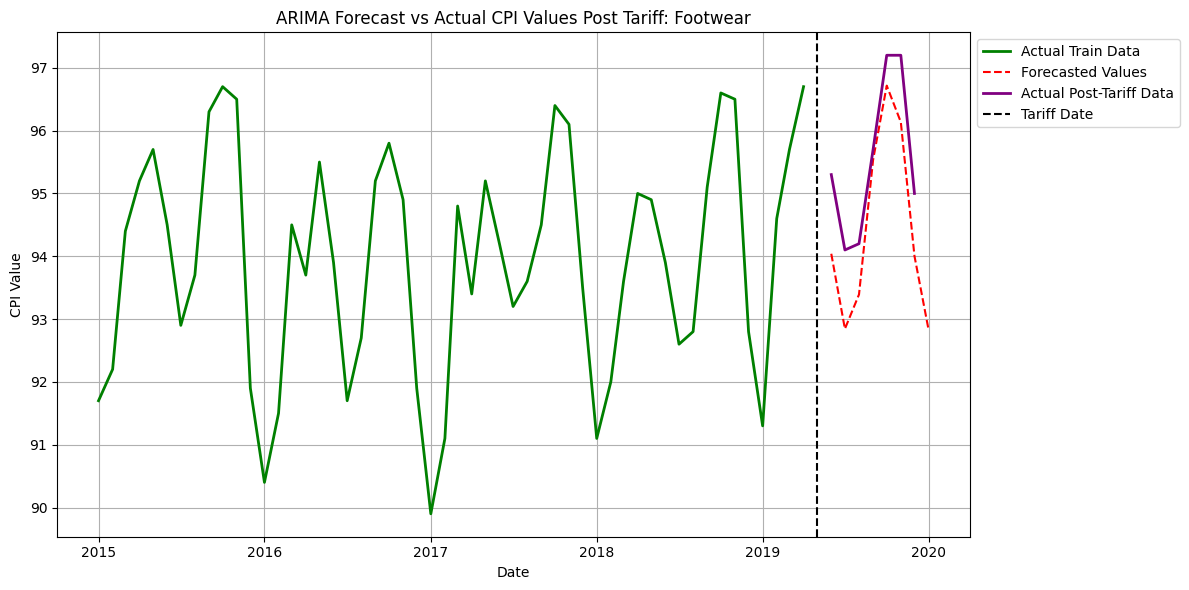

C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


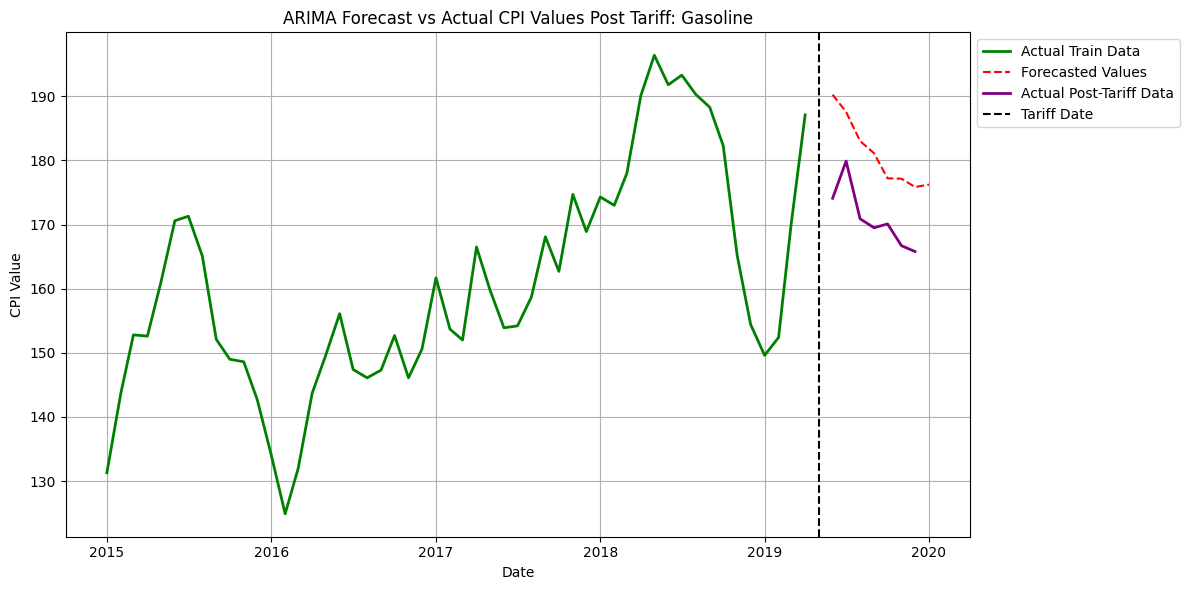

In [16]:
# Getting ARIMA forecasts for the tariff period to the post tariff period
for i in can_categories_df.columns:
    if i in can_cat_list:
        model = arima_model(can_categories_df, i, (5,1,3), '2019-05-01', 8)
        plot_arima_results(can_categories_df, i, model)